In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hdmpy
import statsmodels.api as sm
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
import sys
sys.path.insert(1, "./hdmpy")
import warnings
warnings.filterwarnings("ignore")

### Assignment 1

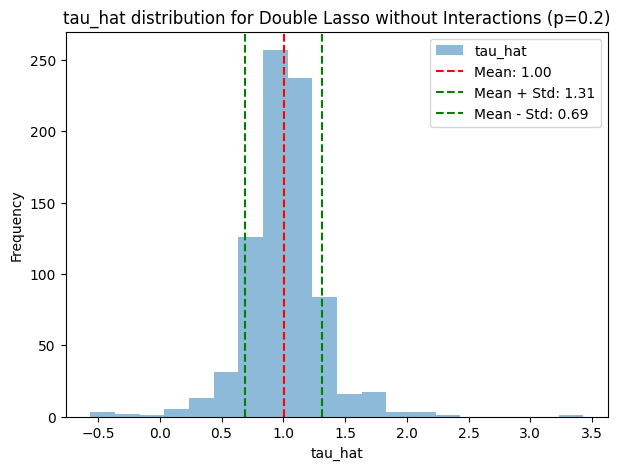

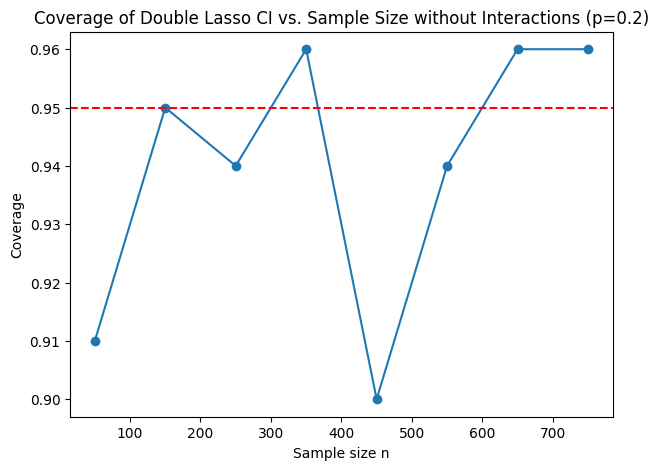

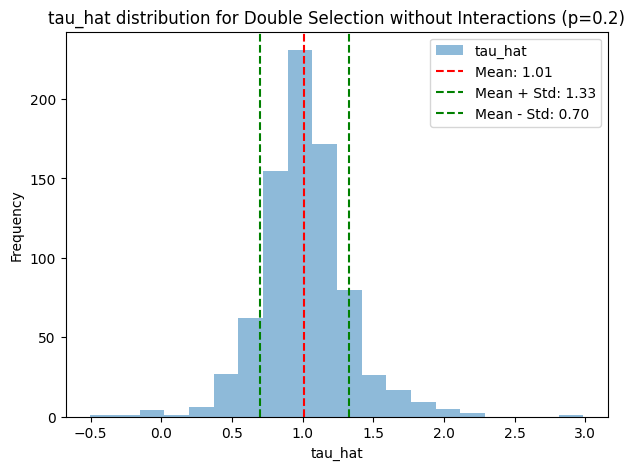

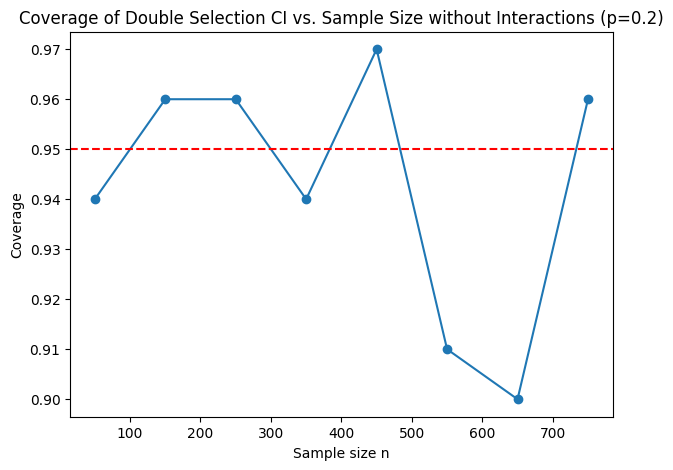

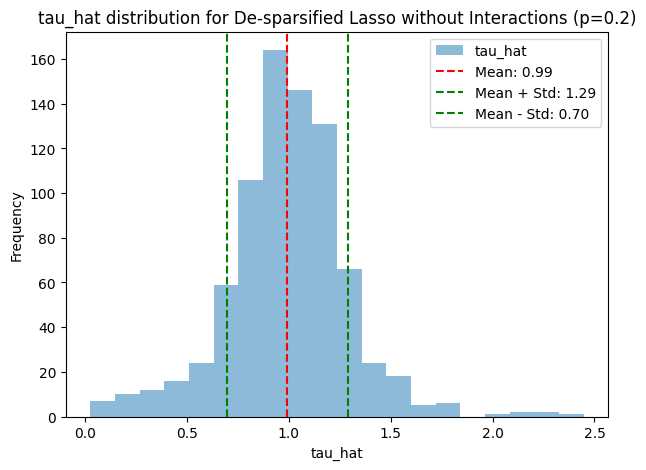

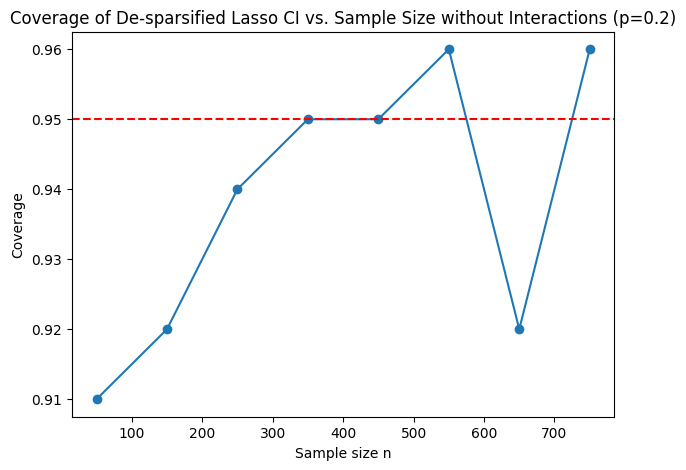

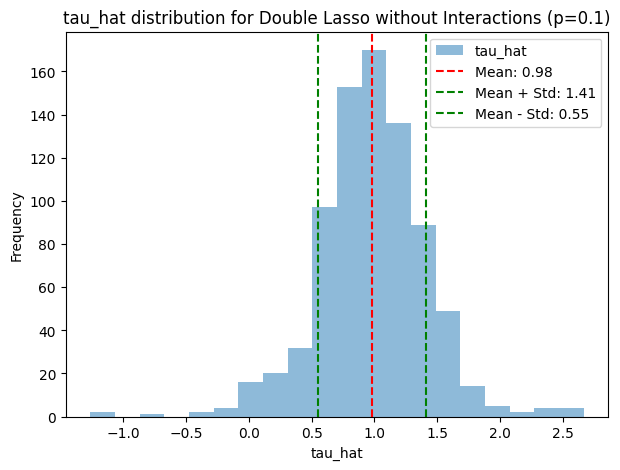

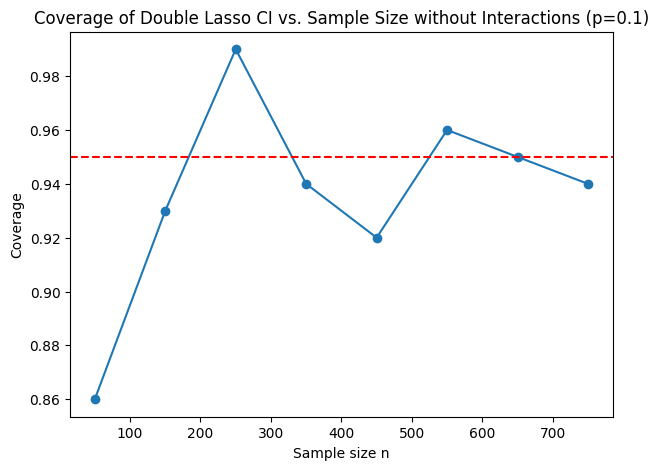

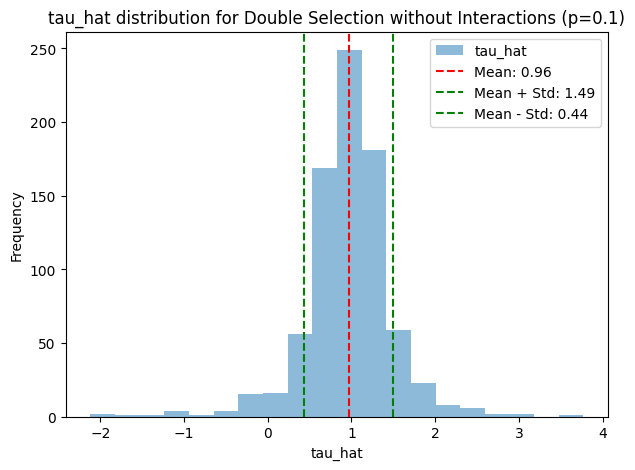

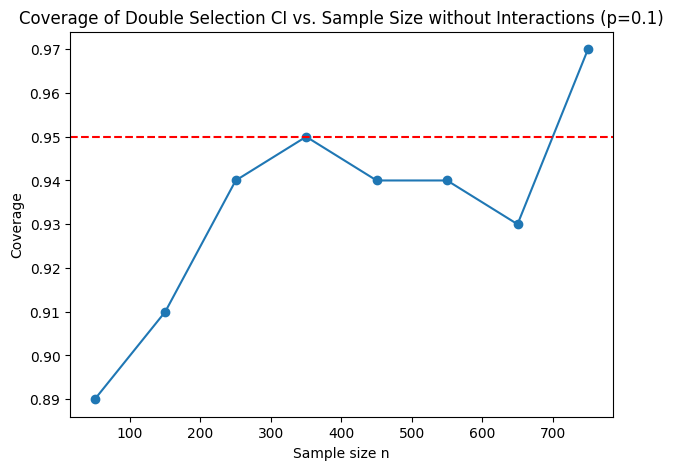

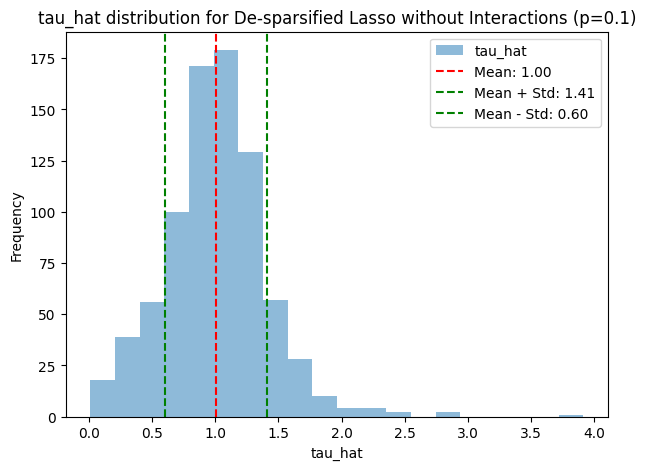

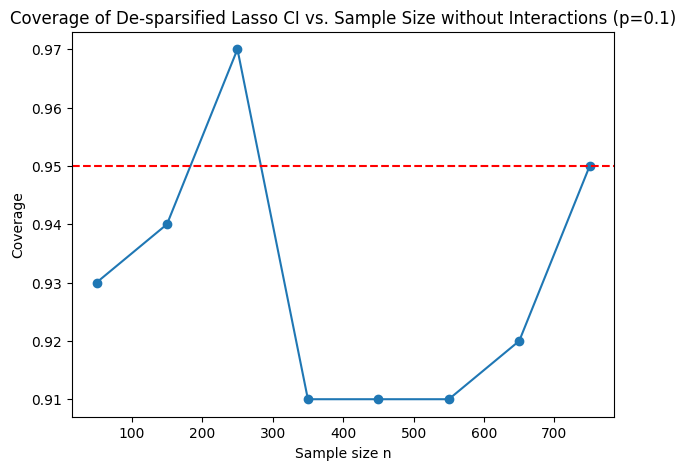

In [7]:
# c.) 

class RLasso(BaseEstimator):

    def __init__(self, *, post=True):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    def predict(self, X):
        return np.array(X) @ np.array(self.rlasso_.est["beta"]).flatten() + np.array(self.rlasso_.est["intercept"])


def lasso_model():
    return RLasso(post=False)


def gen_data(n, d, p, delta, base):
    """
    n: sample size
    d: number of covariates
    p: probability of treatment
    delta: true treatment effect
    base: baseline response
    
    Returns:
        y (n-vector): outcome
        D (n-vector): treatment indicator
        X (n x d): covariates
    """
    D = np.random.binomial(1, p, size=n)
    X = np.random.normal(0, 1, size=(n, d))
    
    # Potential outcomes:
    #  Y(0) = base - X[:,0] + noise
    #  Y(1) = delta + base + X[:,0] + noise
    y0 = base - X[:, 0] + np.random.normal(0, 1, size=n)
    y1 = delta + base + X[:, 0] + np.random.normal(0, 1, size=n)
    
    # Observed outcome:
    y = D * y1 + (1 - D) * y0
    return y, D, X

n_grid = [50, 150, 250, 350, 450, 550, 650, 750]
reps = 100
delta_true = 1.0      # given
d = 10                # dimensionality of X
base = 0.3            # baseline

# double selection procedure
def run_experiment(procedure, reps, delta_true, d, base, p, title, interactions=False):
    coverage_results = []
    tau_hats = []
    for n in n_grid:
        covered_count = 0
        for i in range(reps):
            y, D, X = gen_data(n, d, p, delta_true, base)
            
            tau_hat, se = procedure(y, D, X, interactions)
            tau_hats.append(tau_hat)
            # 95% CI:
            ci_lower = tau_hat - 1.96 * se
            ci_upper = tau_hat + 1.96 * se
            
            # Check coverage:
            if (delta_true >= ci_lower) and (delta_true <= ci_upper):
                covered_count += 1
        coverage = covered_count / reps
        coverage_results.append(coverage)
    
    plt.figure(figsize=(7,5))
    plt.hist(tau_hats, bins=20, alpha=0.5, label="tau_hat")
    plt.axvline(x=np.mean(tau_hats), color="r", linestyle="--", label=f"Mean: {np.mean(tau_hats):.2f}")
    plt.axvline(x=np.mean(tau_hats) + np.std(tau_hats), color="g", linestyle="--", label=f"Mean + Std: {np.mean(tau_hats) + np.std(tau_hats):.2f}")
    plt.axvline(x=np.mean(tau_hats) - np.std(tau_hats), color="g", linestyle="--", label=f"Mean - Std: {np.mean(tau_hats) - np.std(tau_hats):.2f}")
    plt.xlabel("tau_hat")
    plt.ylabel("Frequency")
    if interactions:
        plt.title(f"tau_hat distribution for {title} with Interactions (p={p})")
    else:
        plt.title(f"tau_hat distribution for {title} without Interactions (p={p})")
    plt.legend()
    plt.show()
    
    
    plt.figure(figsize=(7,5))
    plt.plot(n_grid, coverage_results, marker="o", label=f"{title}'s coverage")
    plt.axhline(y=0.95, color="r", linestyle="--", label="95% target")
    plt.xlabel("Sample size n")
    plt.ylabel("Coverage")
    if interactions:
        plt.title(f"Coverage of {title} CI vs. Sample Size with Interactions (p={p})")
    else:
        plt.title(f"Coverage of {title} CI vs. Sample Size without Interactions (p={p})")
    plt.show()

def double_selection(y, D, X, interactions=False):
    scaler = StandardScaler()
    X = X - np.mean(X, axis=0)
    X = scaler.fit_transform(X)
    if interactions:
        X = np.hstack((X, X*D[:, None]))
    lasso = lasso_model()
    lasso.fit(X, y)
    none_zero_idx = np.where(lasso.rlasso_.est["beta"] != 0)[0]
    lasso.fit(X, D)
    none_zero_idx_D = np.where(lasso.rlasso_.est["beta"] != 0)[0]
    non_zero_final = np.union1d(none_zero_idx, none_zero_idx_D)
    X_final = X[:, non_zero_final]
    D = D[:, None]
    X_final = np.hstack((D, X_final))
    final_reg = sm.OLS(y, sm.add_constant(X_final)).fit(cov_type='HC3')
    tau_hat = final_reg.params[1]
    se = final_reg.HC3_se[1]
    return tau_hat, se

def de_sparsified_lasso(y, D, X, interactions=False):
    scaler = StandardScaler()
    X = X - np.mean(X, axis=0)
    X = scaler.fit_transform(X)
    if interactions:
        X = np.hstack((X, X*D[:, None]))
    DX = np.hstack((D[:, None], X))
    lasso_one = lasso_model()
    lasso_one.fit(DX, y)
    DX_untreated = np.hstack((np.zeros((len(D), 1)), X))
    y_hat = y - lasso_one.predict(DX_untreated)
    epsilon = y - lasso_one.predict(DX)
    lasso_two = lasso_model()
    lasso_two.fit(X,D)
    D_hat = D - lasso_two.predict(X)
    tau_hat = np.abs((1.0/np.mean(D*D_hat)) * np.mean(D_hat*y_hat))
    n = len(y)
    se = np.sqrt((1.0/n) * ((np.mean(epsilon**2 * D_hat**2)-np.mean(epsilon*D_hat)**2) / np.mean(D*D_hat)**2))
    return tau_hat, se


def double_lasso(y, D, X, interactions=False):
    scaler = StandardScaler()
    X = X - np.mean(X, axis=0)
    X = scaler.fit_transform(X)
    if interactions:
        X = np.hstack((X, X*D[:, None]))
    lasso_one = lasso_model()
    lasso_one.fit(X, y)
    lasso_two = lasso_model()
    lasso_two.fit(X, D)
    y_hat = y - lasso_one.predict(X)
    D_hat = D - lasso_two.predict(X)
    final_model = sm.OLS(y_hat, D_hat).fit(cov_type='HC3')
    tau_hat = final_model.params[0]
    se = final_model.HC3_se[0]
    return tau_hat, se
    
run_experiment(double_lasso, reps, delta_true, d, base, 0.2, "Double Lasso")
run_experiment(double_selection, reps, delta_true, d, base, 0.2, "Double Selection")
run_experiment(de_sparsified_lasso, reps, delta_true, d, base, 0.2, "De-sparsified Lasso")
run_experiment(double_lasso, reps, delta_true, d, base, 0.1, "Double Lasso")
run_experiment(double_selection, reps, delta_true, d, base, 0.1, "Double Selection")
run_experiment(de_sparsified_lasso, reps, delta_true, d, base, 0.1, "De-sparsified Lasso")


Across repeated runs we have: 

for p = 0.2: double selection and desparsified lasso hava minimally more bias than double lasso, but all have very low bias, within 1% either side of the ground truth. All methods have decent coverage close to the expected .95. All methods have a similar variance, with standard deviations of around .3 across sample sizes

For p = 0.1 de-sparsified lasso has less bias than the other two methods, which have a slightly larger bias. The standard deviations of the methods are all similar (between .4 and .5), but larger than with p=0.1. The coverages of the methods are all similar, again close to the expected .95.

### Assignment 2


In various regions across Europe, we see a correlation between stork populations and birth rates (Matthews, 2000). This joke “evidence” that storks bring babies is driven by confounders that affect both the number of storks and the number of births.

---

Causal Graph:
  
```
+-----------------------------------------------------------------------------------------------------+
                                |  Rurality/Environment|
                                |  Population density  |
                                +----------------------+
                                   /            \
                                  /              \
                                 / (influences)   \ (influences)
                                /                  \
 +------------------+ | Stork Population |     | Birth Rate | +---------------------------------------+
```

  

- **Stork Population (T)**: The so-called “treatment” (erroneously presumed to cause higher birth rates).
- **Birth Rate (O)**: The observed outcome (number of babies per population).
- **Rurality / Environment / Population density etc (C)**: A set of key *confounders* that influences both stork nesting (availability of farmland, conservation efforts, nesting sites) and human fertility behavior (cultural norms, family size preferences, population density, etc.).

Note that it is incredibly unlikely that there is any actual causal relationship between storks and birth rates, hence we leave out the arrow from stork population to birth rate. The correlation is driven by confounders that influence both stork populations and birth rates.

---

What variables or domain knowledge would you need to collect in a dataset in order to apply an identification by conditioning or an identification via propensity scores approach to the estimation of the causal effect?

This case is admittedly slightly ridiculous, since it is clear that storks do not cause babies. Thus "domain expertise" is not really applicable here, although we could of course talk to a avian zoologist specialized in storks, that would likely confirm this. However, if we were to take this seriously from a data perspective, we would collect variables, such as:

- **Land Use / Habitat:** Farmland, wetlands, regulations.  
- **Demographics:** Rural vs. urban splits, age distributions, cultural norms.  
- **Socioeconomics:** Income, education, healthcare access.  
- **Geography / Climate:** Seasonal patterns, temperature, precipitation.  
- **Policy / Infrastructure:** Zoning laws, quality of healthcare.

By conditioning on these variables (e.g., in regression or stratification) or using propensity scores (estimating the likelihood of “high stork population” given habitat/socioeconomic features), we could isolate any direct effect of storks on birth rates (which would extremely unlikely to be non-zero if we do it right).

---

### References

1. **Matthews, R. (2000).** “Storks deliver babies (p = 0.008).” *Teaching Statistics*, 2(2), 70–72.  
   [https://www.researchgate.net/publication/227763292_Storks_Deliver_Babies_p_0008](stork paper)